In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score


import warnings

warnings.filterwarnings("ignore")

encoder = OrdinalEncoder()
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering


sns.set(font_scale=1.5)
# sns.set_style("darkgrid")
sns.set_palette("pastel")

In [19]:
plt.rcParams["figure.figsize"] = [15, 6]

In [20]:
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

<center>


**Table 1: Customer Churn Dataset** 

| Feature          | Description                                           | Type                  |
|------------------|-------------------------------------------------------|-----------------------|
| customerID       | Customer ID, a unique identifier                       | Categorical           |
| gender           | Whether the customer is male or female                 | Categorical           |
| SeniorCitizen    | Whether the customer is a senior citizen (1 or 0)      | Dichotomous categorical |
| Partner          | Whether the customer has a partner (Yes or No)         | Categorical           |
| Dependents       | Whether the customer has dependents (Yes or No)        | Categorical           |
| tenure           | Number of months the customer has stayed               | Integer-valued         |
| PhoneService     | Whether the customer has phone service (Yes or No)      | Categorical           |
| MultipleLines    | Whether the customer has multiple lines                | Categorical           |
| InternetService  | Customer’s internet service provider                   | Categorical           |
| OnlineSecurity   | Whether the customer has online security               | Categorical           |
| OnlineBackup     | Whether the customer has online backup                 | Categorical           |
| DeviceProtection | Whether the customer has device protection             | Categorical           |
| TechSupport      | Whether the customer has tech support                  | Categorical           |
| StreamingTV      | Whether the customer has streaming TV                  | Categorical           |
| StreamingMovies  | Whether the customer has streaming movies              | Categorical           |
| Contract         | The contract term of the customer                      | Categorical           |
| PaperlessBilling | Whether the customer has paperless billing             | Categorical           |
| PaymentMethod    | The customer’s payment method                          | Categorical           |
| MonthlyCharges   | The amount charged to the customer monthly             | Continuous            |
| TotalCharges     | The total amount charged to the customer               | Continuous            |
| Churn            | Whether the customer churned (Yes or No)               | Categorical           |

</center>

In [4]:
data = data.drop(columns="customerID")

In [5]:
data.drop_duplicates(inplace=True)

In [6]:
data.drop("TotalCharges", axis=1, inplace=True)

In [7]:
nominal_features = ("PaperlessBilling", "Dependents", "Partner", "Churn")
for feature in nominal_features:
    data[feature] = data[feature].map({"Yes": 1, "No": 0})

In [8]:
data[["tenure", "MonthlyCharges"]].describe()

,tenure,MonthlyCharges
count,7021.000000,7021.000000
mean,32.469449,64.851894
std,24.534965,30.069001
min,0.000000,18.250000
25%,9.000000,35.750000
50%,29.000000,70.400000
75%,55.000000,89.900000
max,72.000000,118.750000


In [9]:
df_cluster = data.copy()

In [10]:
scaler = StandardScaler()
df_cluster[["tenure", "MonthlyCharges"]] = scaler.fit_transform(
    df_cluster[["tenure", "MonthlyCharges"]]
)

df_cluster[
    df_cluster.columns[~df_cluster.columns.isin(["tenure", "MonthlyCharges"])]
] = encoder.fit_transform(
    df_cluster[
        df_cluster.columns[~df_cluster.columns.isin(["tenure", "MonthlyCharges"])]
    ]
)

## Wybór rozmiaru klastrów

### Metoda Elbow (Łokieć):

- Wykorzystuje sumę kwadratów odległości między punktami danych a środkami klastrów.
- Dla różnej liczby klastrów, oblicza się sumę kwadratów błędów (SSE).
- Następnie rysuje się wykres SSE dla różnych liczby klastrów.
- Na wykresie szuka się punktu, w którym dalsze zwiększanie liczby klastrów nie powoduje już znaczącej redukcji błędu. Ten punkt przypomina łokieć, stąd nazwa metody.

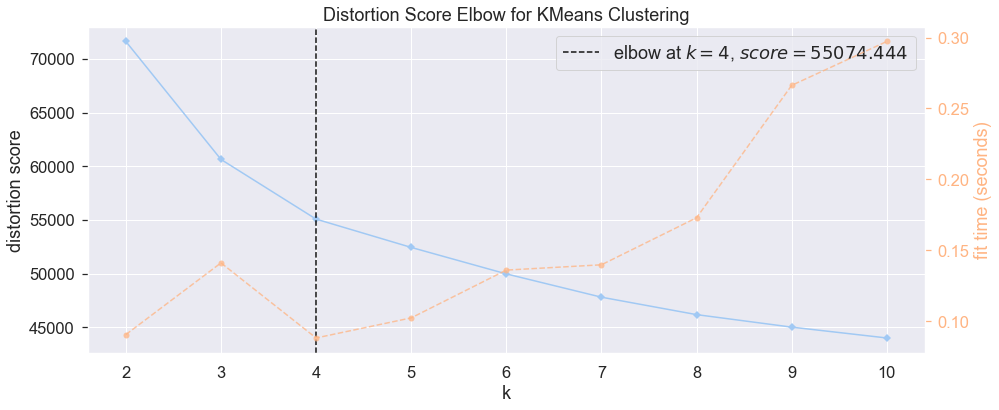

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [32]:
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(df_cluster)
Elbow_M.show()

To samo, ale za pomocą innej biblioteki

In [40]:
def optimise_k_means_elbow_method(data, max_k):
    means = []
    inertias = []

    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        means.append(k)
        inertias.append(kmeans.inertia_)

    plt.plot(means, inertias, "o-", color="black")
    plt.xlabel("Number of Clusters")
    plt.title("Elbow Method For Optimal k")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.show()

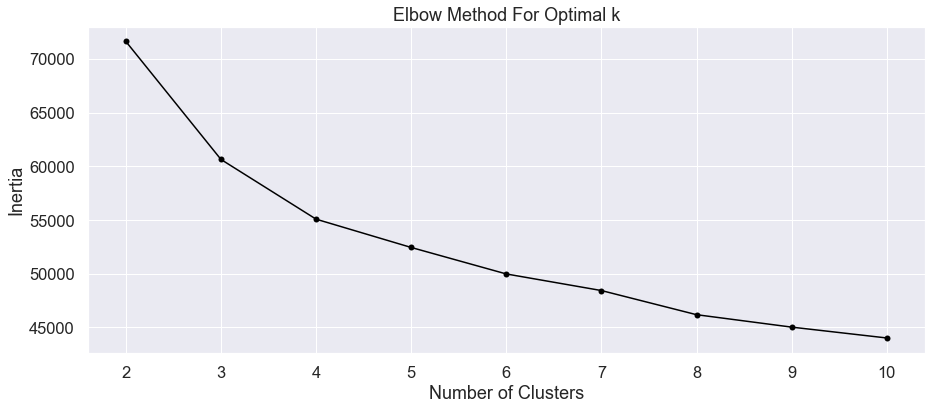

In [41]:
optimise_k_means_elbow_method(df_cluster, 10)

### Metoda Silhouette
- Wykorzystuje miarę silhouette, która ocenia, jak dobrze punkt danych pasuje do swojego klastra w porównaniu z sąsiednimi klastrami.
- Dla różnych liczby klastrów oblicza się średnią wartość silhouette.
- Wybiera się liczbę klastrów, dla której wartość silhouette jest maksymalna.

In [45]:
def optimise_k_means_silhouette_score(data, max_k):
    means = []
    silhouette = []

    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        means.append(k)
        silhouette.append(silhouette_score(data, kmeans.labels_))

    plt.plot(means, silhouette, "o-", color="black")
    plt.xlabel("Number of Clusters")
    plt.title(
        "Comparison of Average Silhouette Scores for Different Numbers of Clusters"
    )
    plt.ylabel("Average Silhouette Score")
    plt.grid(True)
    plt.show()

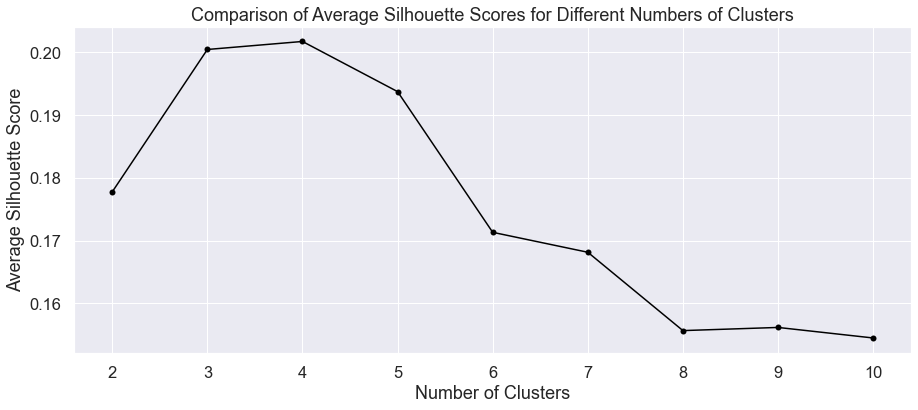

In [46]:
optimise_k_means_silhouette_score(df_cluster, 10)

### Metoda Daviesa-Bouldina

Kluczowym celem tej metody jest minimalizacja stosunku między średnimi odległościami wewnątrz klastrów a odległościami między klastrami dla różnych liczby klastrów.
W praktyce, optymalna liczba klastrów to taka, dla której ten stosunek jest minimalny. Oznacza to, że klastry są zarówno kompaktowe, jak i dobrze odseparowane od siebie.
Podsumowując, Metoda Daviesa-Bouldina stara się znaleźć taką liczbę klastrów, dla której klastry są jednocześnie jak najbardziej zwarte wewnętrznie i jak najbardziej odległe od siebie nawzajem. Minimalizacja stosunku między tymi dwiema miarami sugeruje optymalną strukturę klastrów w analizowanym zbiorze danych.

In [68]:
def optimise_k_means_davies_bouldin(data, max_k):
    davies_bouldin_scores = []

    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        db_index = davies_bouldin_score(data, kmeans.labels_)
        davies_bouldin_scores.append(db_index)

    plt.plot(range(2, max_k + 1), davies_bouldin_scores, "o-", color="black")
    plt.xlabel("Number of Clusters")
    plt.title("Davies-Bouldin Index for Different Numbers of Clusters")
    plt.ylabel("Davies-Bouldin Index")
    plt.grid(True)
    plt.show()

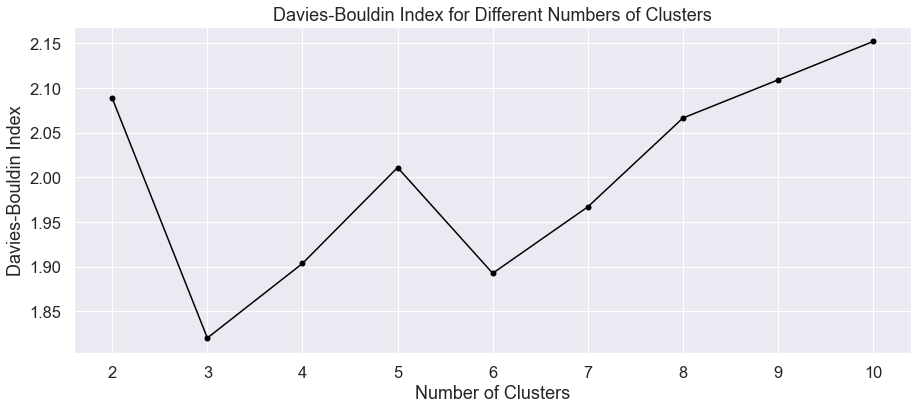

In [69]:
optimise_k_means_davies_bouldin(df_cluster, 10)

Wybierz punkt łokcia lub minimalnej wartości:

Podobnie jak w przypadku metody łokcia, możesz przyjąć punkt, w którym wartość Daviesa-Bouldina zaczyna się stabilizować lub osiąga minimum, jako optymalną liczbę klastrów.
Możesz również zbadać obszary wokół potencjalnych punktów optymalnych, aby potwierdzić stabilność wyboru.

### Metoda Celiński Harbasz

Indeks Calinski-Harabasz, znany także jako Kryterium Stosunku Wariancji, to wskaźnik wewnętrznej oceny klastrów, używany do oceny jakości klastrów w zestawie danych. Mierzy stosunek wariancji między klastrami do wariancji wewnątrz klastrów. Indeks ten osiąga wyższe wartości, gdy klastry są dobrze oddzielone i skoncentrowane.

In [76]:
def optimise_k_means_calinski_harbasz(data, max_k):
    calinski_harabasz_scores = []

    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k)
        labels = kmeans.fit_predict(data)
        ch_index = calinski_harabasz_score(data, labels)
        calinski_harabasz_scores.append(ch_index)

    plt.plot(
        range(2, max_k + 1),
        calinski_harabasz_scores,
        "o-",
        label="Calinski-Harabasz Index",
        color="black",
    )
    plt.title("Calinski-Harabasz Index for Different Numbers of Clusters")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Calinski-Harabasz Index")
    plt.grid(True)
    plt.legend()
    plt.show()

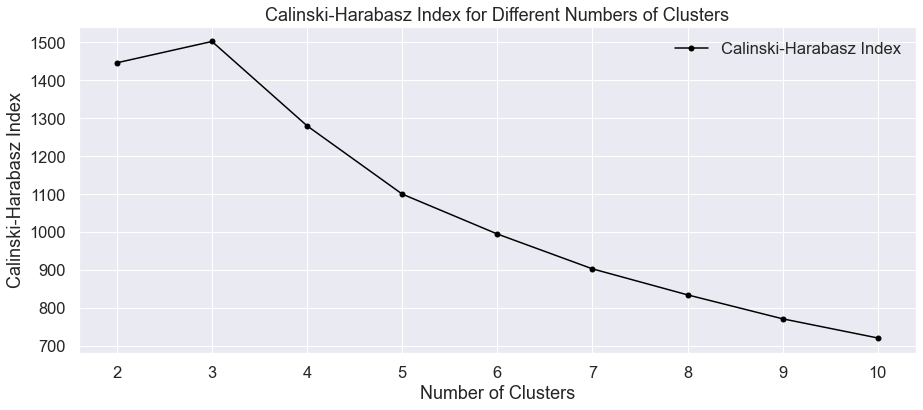

In [77]:
optimise_k_means_calinski_harbasz(df_cluster, 10)

### Analiza Hierarchiczna:

- jak często klastry dzielą się na różnych poziomach drzewa.
- Kiedy kolejne podziały nie przynoszą znaczącej korzyści, możesz uznać tę liczbę klastrów za optymalną.

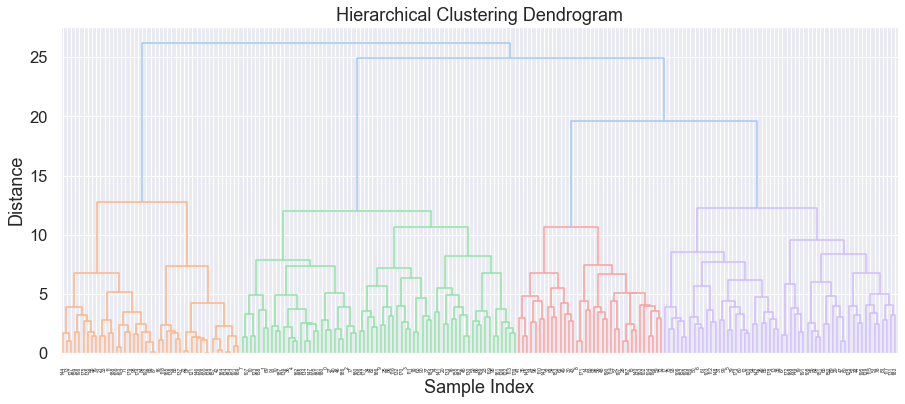

In [66]:
linkage_matrix = linkage(
    df_cluster[:200], method="ward"
)  # dałam okrojony zbiór, bo inaczej za długo liczyło
dendrogram(linkage_matrix)
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.title("Hierarchical Clustering Dendrogram")
plt.show()

## Wizualizacja

# 4 klastry

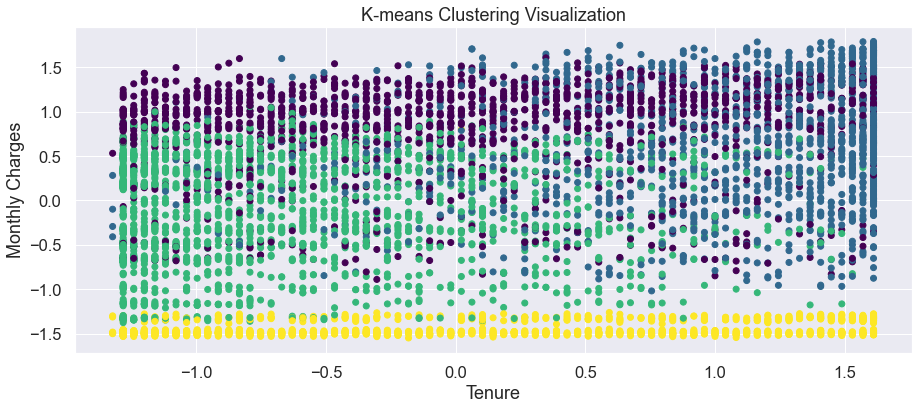

In [50]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_cluster)
plt.scatter(
    df_cluster["tenure"], df_cluster["MonthlyCharges"], c=kmeans.labels_, cmap="viridis"
)

plt.xlabel("Tenure")
plt.ylabel("Monthly Charges")
plt.title("K-means Clustering Visualization")
plt.show()

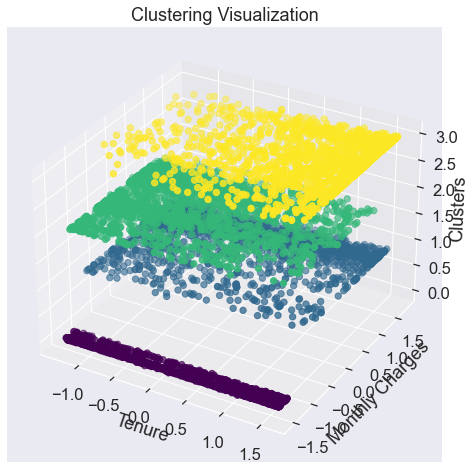

In [29]:
AC = AgglomerativeClustering(n_clusters=4)
yhat_AC = AC.fit_predict(df_cluster)
df_cluster["Clusters"] = yhat_AC
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111, projection="3d")
ax.scatter(
    df_cluster["tenure"],
    df_cluster["MonthlyCharges"],
    df_cluster["Clusters"],
    s=40,
    c=df_cluster["Clusters"],
    marker="o",
    cmap="viridis",
)
ax.set_xlabel("Tenure")
ax.set_ylabel("Monthly Charges")
ax.set_zlabel("Clusters")
ax.set_title("Clustering Visualization")
plt.show()

# 3 klastry

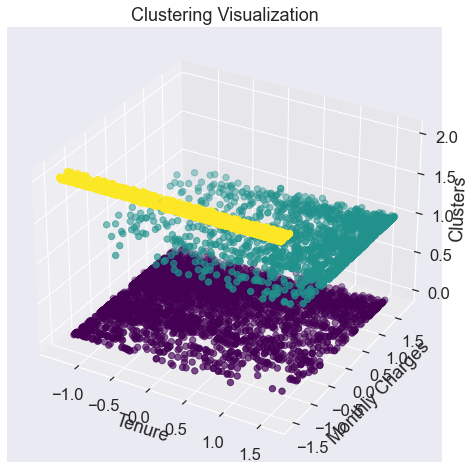

In [70]:
AC = AgglomerativeClustering(n_clusters=3)
yhat_AC = AC.fit_predict(df_cluster)
df_cluster["Clusters"] = yhat_AC
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111, projection="3d")
ax.scatter(
    df_cluster["tenure"],
    df_cluster["MonthlyCharges"],
    df_cluster["Clusters"],
    s=40,
    c=df_cluster["Clusters"],
    marker="o",
    cmap="viridis",
)
ax.set_xlabel("Tenure")
ax.set_ylabel("Monthly Charges")
ax.set_zlabel("Clusters")
ax.set_title("Clustering Visualization")
plt.show()

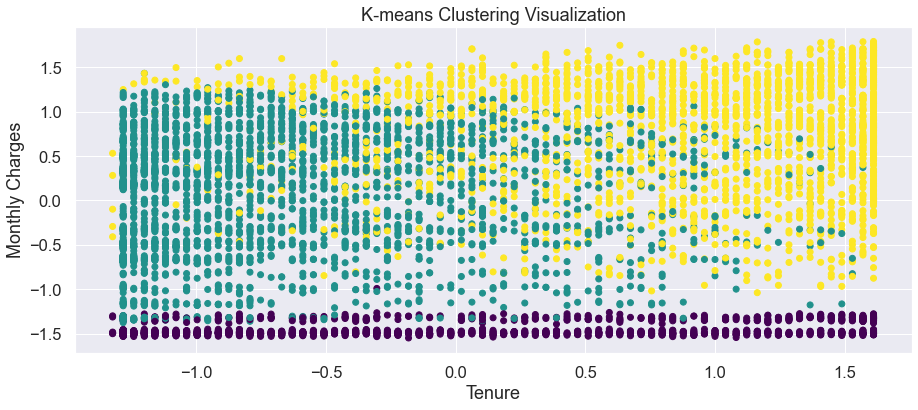

In [71]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_cluster)
plt.scatter(
    df_cluster["tenure"], df_cluster["MonthlyCharges"], c=kmeans.labels_, cmap="viridis"
)

plt.xlabel("Tenure")
plt.ylabel("Monthly Charges")
plt.title("K-means Clustering Visualization")
plt.show()

WNIOSKI: 3 LUB 4 KLASTRY(NIE 2 JAK INTUICJA PODPOWIADAŁA). WYBIERAMY 4?